In [1]:
import time
import random
import threading

import numpy as np
import matplotlib.pyplot as plt

import cst_python as cst

In [2]:
class OscillatorCodelet(cst.Codelet):
    def __init__(self, name:str) -> None:
        super().__init__()

        self.name = name
        self._ascending = True

    def access_memory_objects(self) -> None:
        pass

    def calculate_activation(self) -> None:
        if self._ascending:
            step = 0.1
        else:
            step = -0.1

        try:
            self.activation += step
        except ValueError:
            self._ascending = not self._ascending

    def proc(self) -> None:
        pass



In [3]:
class SensorCodelet(cst.Codelet):
    def __init__(self, name:str) -> None:
        super().__init__()

        self.name = name
        self._ascending = True

        self._input_mo : cst.MemoryObject = None
        self._output_mo : cst.MemoryObject = None
        self._n_run = 0

    def access_memory_objects(self) -> None:
        self._input_mo = self.get_input(name="SensoryInput")
        self._output_mo = self.get_output(name="SensoryOutput")

    def calculate_activation(self) -> None:
        pass

    def proc(self) -> None:
        #print("RUN", end=" ")
        read_value : float = self._input_mo.get_info()
        #print(read_value, read_value is None)
        read_value *= 10

        self._output_mo.set_info(read_value)


In [4]:
class MotorCodelet(cst.Codelet):
    def __init__(self, name:str) -> None:
        super().__init__()

        self.name = name
        self._ascending = True

        self._minput_mo : cst.MemoryObject = None
        self._output_mo : cst.MemoryObject = None

    def access_memory_objects(self) -> None:
        self._minput_mo = self.get_input(name="SensoryOutput")
        self._output_mo = self.get_output(name="Action")

    def calculate_activation(self) -> None:
        pass

    def proc(self) -> None:
        read_value : float = self._minput_mo.get_info()
        
        action = read_value > 5 

        self._output_mo.set_info(action)

In [5]:
def prepare_mind() -> cst.Mind:
    mind = cst.Mind()

    mind.create_codelet_group("Sensory")
    mind.create_codelet_group("Perception")
    mind.create_codelet_group("Behavioral")
    mind.create_codelet_group("Motivational")
    mind.create_codelet_group("Motor")
    mind.create_codelet_group("StandardMemories")
    mind.create_codelet_group("Containers")

    m1 = mind.create_memory_object("SensoryInput", 1.12)
    mind.register_memory(m1,"StandardMemories")

    m3 = mind.create_memory_object("SensoryOutput", 3.44)
    mind.register_memory(m3,"StandardMemories")
    m5 = mind.create_memory_object("Action", False)
    mind.register_memory(m5,"StandardMemories")
    

    c = SensorCodelet("Sensor1")
    c.add_input(m1)
    c.add_output(m3)
    mind.insert_codelet(c,"Sensory")

    c2 = MotorCodelet("Motor1")
    c2.add_input(m3)
    c2.add_output(m5)
    mind.insert_codelet(c2,"Motor")

    c3 = OscillatorCodelet("Curiosity")
    mind.insert_codelet(c3, "Motivational")

    c.time_step = 100
    c2.time_step = 100
    c3.time_step = 100

    mind.start()
    
    return mind

In [6]:
mind = prepare_mind()

In [7]:
input_memory = mind.raw_memory.get_all_of_type("SensoryInput")[0]
sensory_output_memory = mind.raw_memory.get_all_of_type("SensoryOutput")[0]
action_memory = mind.raw_memory.get_all_of_type("Action")[0]

for codelet in mind.code_rack.all_codelets:
    if isinstance(codelet, OscillatorCodelet):
        oscillator_codelet = codelet
        break

In [8]:
sleep_time = (oscillator_codelet.time_step/2)/1000

In [9]:
threading.active_count()

9

In [10]:
n_step = 100

activation_hist = np.empty(n_step, dtype=np.float64)
input_hist = np.empty(n_step, dtype=np.float64)
sensory_output_hist = np.empty(n_step, dtype=np.float64)
action_hist = np.empty(n_step, dtype=bool)

for i in range(n_step):
    input_value = random.random()
    
    input_memory.set_info(input_value)

    input_hist[i] = input_memory.get_info()
    sensory_output_hist[i] = sensory_output_memory.get_info()
    action_hist[i] = action_memory.get_info()
    activation_hist[i] = oscillator_codelet.activation
    
    time.sleep(sleep_time)

In [11]:
mind.shutdown()
time.sleep(1)
threading.active_count()

6

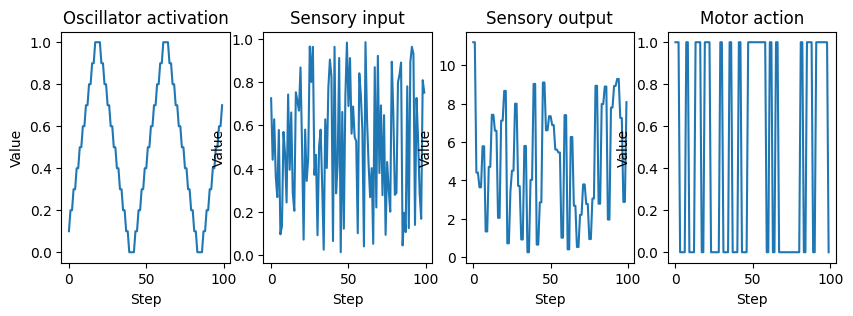

In [24]:
fig, axs  = plt.subplots(1, 4, figsize=(10, 3))

axs : list[plt.Axes]

axs[0].plot(activation_hist)
axs[0].set_title("Oscillator activation")

axs[1].plot(input_hist)
axs[1].set_title("Sensory input")

axs[2].plot(sensory_output_hist)
axs[2].set_title("Sensory output")

axs[3].plot(action_hist)
axs[3].set_title("Motor action")

for ax in axs:
    ax.set_xlabel("Step")
    ax.set_ylabel("Value")

plt.show()

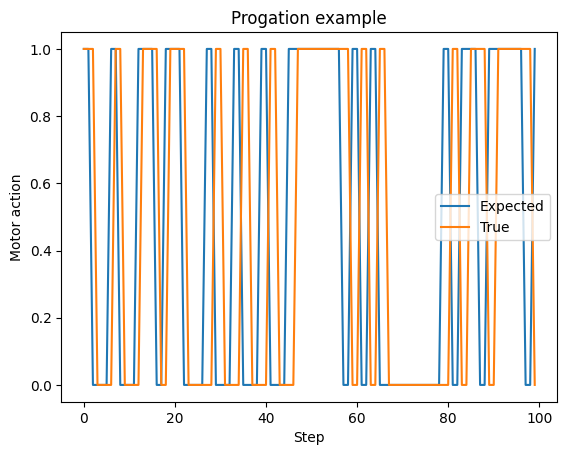

In [29]:
plt.title("Progation example")
plt.xlabel("Step")
plt.ylabel("Motor action")

plt.plot(sensory_output_hist>5, label="Expected")
plt.plot(action_hist, label="True")

plt.legend()